In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
import torch.optim as optim
from torchvision import datasets,transforms
from model import *
import math

## Utils

### Dataset

In [48]:
class MNIST_class(Dataset):
    def __init__(self, cl, train = True):
        super().__init__()
        data = datasets.MNIST(root = "data", train = train, transform= transforms.ToTensor())
        X = data.data
        y = data.targets
        self.X = X[y == cl]
        self.y = cl * np.ones(self.X.shape[0])
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        x = torch.tensor(self.X[index], dtype = torch.float)
        y = torch.tensor(self.y[index], dtype= torch.long)
        return x, y


In [49]:
## ----------------------------------------------------------------------------
## Visualise a sample batch
## ----------------------------------------------------------------------------

def display_images(images, n_cols=4, figsize=(12, 6)):
    """
    Utility function to display a collection of images in a grid
    
    Parameters
    ----------
    images: Tensor
            tensor of shape (batch_size, channel, height, width)
            containing images to be displayed
    n_cols: int
            number of columns in the grid
            
    Returns
    -------
    None
    """
    plt.style.use('ggplot')
    n_images = len(images)
    n_rows = math.ceil(n_images / n_cols)
    plt.figure(figsize=figsize)
    for idx in range(n_images):
        ax = plt.subplot(n_rows, n_cols, idx+1)
        image = images[idx]
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])        
    plt.tight_layout()
    plt.show()


### Losses

In [50]:
def real_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are drawn from real dataset
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    real_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 1 here because we expect prediction to be 
    # 1 (or near 1) since samples are drawn from real dataset
    targets = torch.ones(batch_size).to(device)
    real_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return real_loss


def fake_loss(predicted_outputs, loss_fn, device):
    """
    Function for calculating loss when samples are generated fake samples
    
    Parameters
    ----------
    predicted_outputs: Tensor
                       predicted logits
            
    Returns
    -------
    fake_loss: int
    """
    batch_size = predicted_outputs.shape[0]
    # Targets are set to 0 here because we expect prediction to be 
    # 0 (or near 0) since samples are generated fake samples
    targets = torch.zeros(batch_size).to(device)
    fake_loss = loss_fn(predicted_outputs.squeeze(), targets)
    
    return fake_loss 

In [51]:
# Training loop function

def train_minst_gan(d, g, z_size, d_optim, g_optim, loss_fn, dl, n_epochs, device, verbose=False):
    print(f'Training on [{device}]...')
    
    # Generate a batch (say 16) of latent image vector (z) of fixed size 
    # (say 100 pix) to be as input to the Generator after each epoch of 
    # training to generate a fake image. We'll visualise these fake images
    # to get a sense how generator improves as training progresses
    fixed_z = np.random.uniform(-1, 1, size=(16, z_size))
    fixed_z = torch.from_numpy(fixed_z).float().to(device)          
    fixed_samples = []
    d_losses = []
    g_losses = []
    
    
    # Move discriminator and generator to available device
    d = d.to(device)
    g = g.to(device)
    
    for epoch in range(n_epochs):
        print(f'Epoch [{epoch+1}/{n_epochs}]:')
        # Switch the training mode on
        d.train()
        g.train()
        d_running_batch_loss = 0
        g_running_batch_loss = 0
        for curr_batch, (real_images, _) in enumerate(dl):
            # Move input batch to available device
            real_images = real_images.to(device)
            
            ## ----------------------------------------------------------------
            ## Train discriminator using real and then fake MNIST images,  
            ## then compute the total-loss and back-propogate the total-loss
            ## ----------------------------------------------------------------
            
            # Reset gradients
            d_optim.zero_grad()
            
            # Real MNIST images
            # Convert real_images value range of 0 to 1 to -1 to 1
            # this is required because latter discriminator would be required 
            # to consume generator's 'tanh' output which is of range -1 to 1
            real_images = ((real_images / 255) * 2) - 1  
            d_real_logits_out = d(real_images)
            d_real_loss = real_loss(d_real_logits_out, loss_fn, device)
            #d_real_loss = real_loss(d_real_logits_out, smooth=True)
            
            # Fake images
            with torch.no_grad():
                # Generate a batch of random latent vectors 
                z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
                z = torch.from_numpy(z).float().to(device)
                # Generate batch of fake images
                fake_images = g(z) 
            # feed fake-images to discriminator and compute the 
            # fake_loss (i.e. target label = 0)
            d_fake_logits_out = d(fake_images)
            d_fake_loss = fake_loss(d_fake_logits_out, loss_fn, device)
            #d_fake_loss = fake_loss(d_fake_logits_out)
            # Compute total discriminator loss
            d_loss = d_real_loss + d_fake_loss
            # Backpropogate through discriminator
            d_loss.backward()
            d_optim.step()
            # Save discriminator batch loss
            d_running_batch_loss += d_loss
            
            ## ----------------------------------------------------------------
            ## Train generator, compute the generator loss which is a measure
            ## of how successful the generator is in tricking the discriminator 
            ## and finally back-propogate generator loss
            ## ----------------------------------------------------------------

            # Reset gradients
            g_optim.zero_grad()
            
            # Generate a batch of random latent vectors
            #z = torch.rand(size=(dl.batch_size, z_size)).to(device)
            z = np.random.uniform(-1, 1, size=(dl.batch_size, z_size))
            z = torch.from_numpy(z).float().to(device)       
            # Generate a batch of fake images, feed them to discriminator
            # and compute the generator loss as real_loss 
            # (i.e. target label = 1)
            fake_images = g(z) 
            g_logits_out = d(fake_images)
            g_loss = real_loss(g_logits_out, loss_fn, device)
            #g_loss = real_loss(g_logits_out)
            # Backpropogate thorugh generator
            g_loss.backward()
            g_optim.step()
            # Save discriminator batch loss
            g_running_batch_loss += g_loss
            
            # Display training stats for every 200 batches 
            if curr_batch % 400 == 0 and verbose:
                print(f'\tBatch [{curr_batch:>4}/{len(dl):>4}] - d_batch_loss: {d_loss.item():.6f}\tg_batch_loss: {g_loss.item():.6f}')
            
        # Compute epoch losses as total_batch_loss/number_of_batches
        d_epoch_loss = d_running_batch_loss.item()/len(dl)
        g_epoch_loss = g_running_batch_loss.item()/len(dl)
        d_losses.append(d_epoch_loss)
        g_losses.append(g_epoch_loss)
        
        # Display training stats for every 200 batches 
        print(f'epoch_d_loss: {d_epoch_loss:.6f} \tepoch_g_loss: {g_epoch_loss:.6f}')
        
        # Generate fake images from fixed latent vector using the trained 
        # generator so far and save images for latter viewing
        g.eval()
        fixed_samples.append(g(fixed_z).detach().cpu())
        
    # Finally write generated fake images from fixed latent vector to disk
    with open('fixed_samples.pkl', 'wb') as f:
        pkl.dump(fixed_samples, f)
     
    return d_losses, g_losses

In [52]:
##
## Visualize image generation improvements
##

def show_generated_images(epoch, n_cols=8):
    # load saved images
    with open('fixed_samples.pkl', 'rb') as f:
        saved_data = pkl.load(f)  
    epoch_data = saved_data[epoch-1]
    # re-scale back to 0-1 
    epoch_data = (epoch_data + 1) / 2
    # re-shape to (batch_size, channel, height, width)
    batch_size, height, width = len(epoch_data), 28, 28
    image_batch = epoch_data.view(batch_size, height, width)
    display_images(images=image_batch, n_cols=n_cols, figsize=(12, 4))

## Class 0

In [53]:
cl = 0
train_data = MNIST_class(cl, True)
test_data = MNIST_class(cl, False)

### Dataloaders

In [54]:
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)

### Visualizing a training batch

In [55]:
# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)

2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


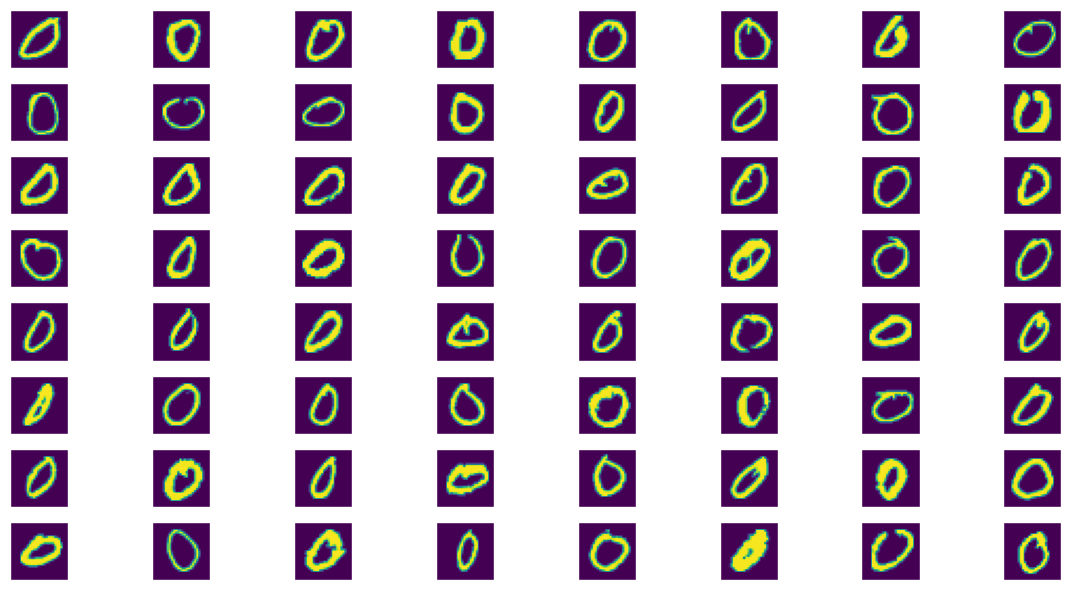

In [56]:
display_images(images=image_batch[0], n_cols=8)

## Train the network

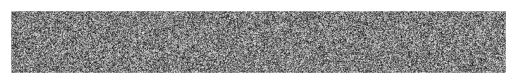

In [57]:
#Sample generation of latent vector
z_size = 784
z = np.random.uniform(-1, 1, size=(100, z_size))
plt.imshow(z, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [59]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.687297 	epoch_g_loss: 1.932019
Epoch [2/400]:
epoch_d_loss: 0.447167 	epoch_g_loss: 2.916324
Epoch [3/400]:
epoch_d_loss: 0.436708 	epoch_g_loss: 4.321693
Epoch [4/400]:
epoch_d_loss: 0.709436 	epoch_g_loss: 4.004496
Epoch [5/400]:
epoch_d_loss: 0.794612 	epoch_g_loss: 4.078874
Epoch [6/400]:
epoch_d_loss: 0.697456 	epoch_g_loss: 3.571549
Epoch [7/400]:
epoch_d_loss: 1.022846 	epoch_g_loss: 2.415227
Epoch [8/400]:
epoch_d_loss: 0.962759 	epoch_g_loss: 2.095103
Epoch [9/400]:
epoch_d_loss: 1.012583 	epoch_g_loss: 2.480392
Epoch [10/400]:
epoch_d_loss: 0.966884 	epoch_g_loss: 2.192834
Epoch [11/400]:
epoch_d_loss: 0.965417 	epoch_g_loss: 1.863385
Epoch [12/400]:
epoch_d_loss: 0.882643 	epoch_g_loss: 1.894884
Epoch [13/400]:
epoch_d_loss: 0.767932 	epoch_g_loss: 2.081879
Epoch [14/400]:
epoch_d_loss: 0.677409 	epoch_g_loss: 2.353074
Epoch [15/400]:
epoch_d_loss: 0.723536 	epoch_g_loss: 2.333331
Epoch [16/400]:
epoch_d_loss: 0.510120 	epoch_g_loss: 2.391932
Epoch [17/400]:


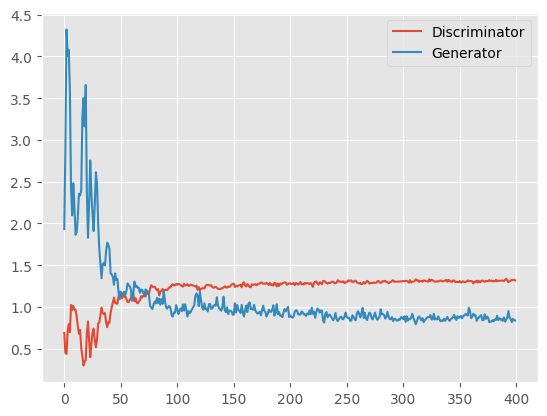

In [60]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

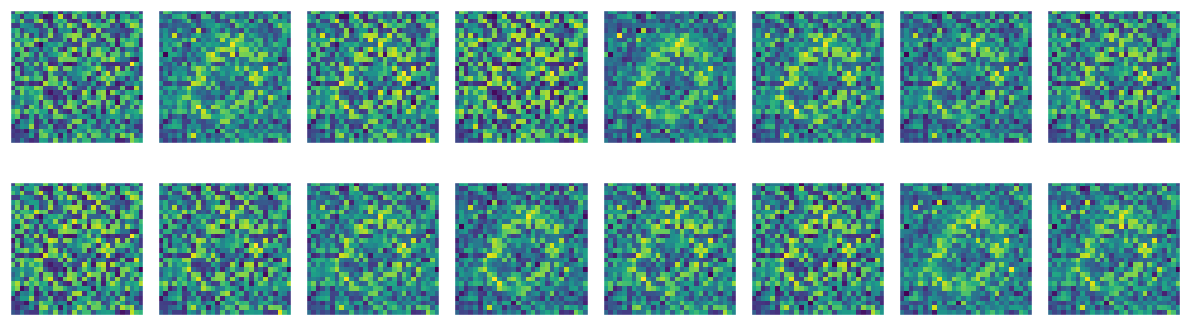

In [61]:
show_generated_images(epoch=1, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

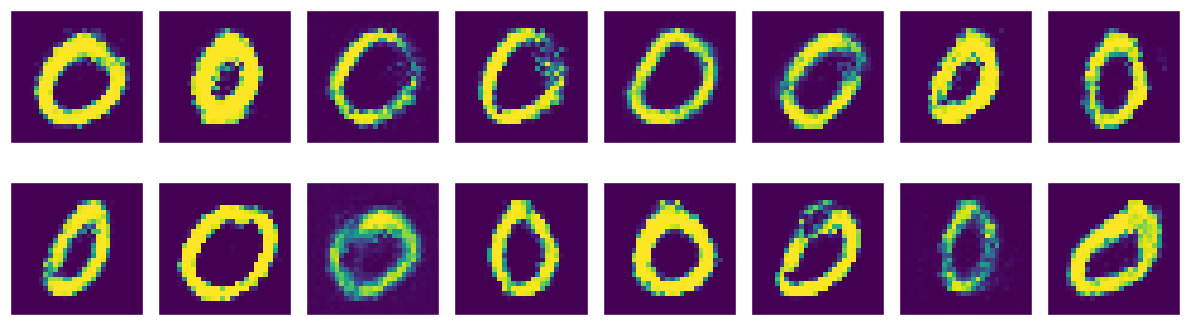

In [62]:
show_generated_images(epoch=100, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

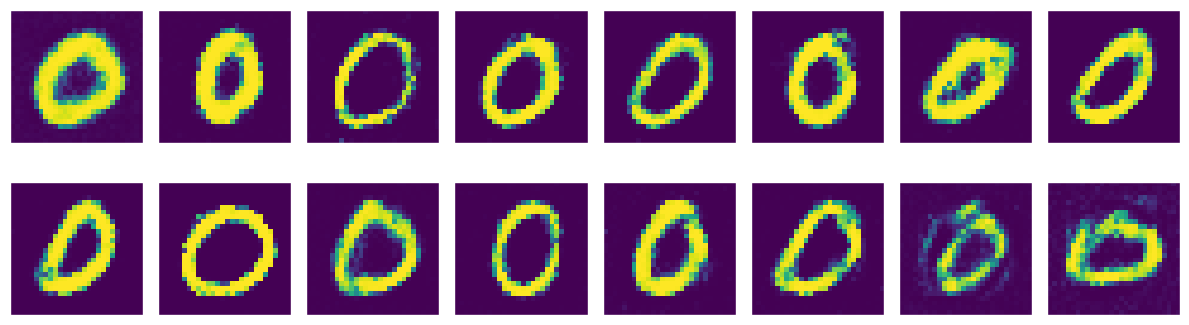

In [63]:
show_generated_images(epoch=200, n_cols=8)

## Test the network

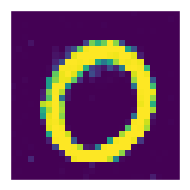

The discriminator s opinion is :  -0.4202973246574402


In [64]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [65]:
torch.save(g.state_dict(), f'./mnist_models/gan-generator-mnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./mnist_models/gan-discriminator-mnist-cl-{cl}.pth')

In [224]:
x = np.random.uniform(-1, 1, size=(1, 28, 28))
t = torch.tensor(x, dtype = float)
t = t.view(1, 28, 28).float()
d(t)


tensor([[-10.4284]], grad_fn=<AddmmBackward0>)

## CLass 1

In [66]:
cl = 1
train_data = MNIST_class(cl, True)
test_data = MNIST_class(cl, False)

In [67]:
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)

In [68]:
# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)

2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


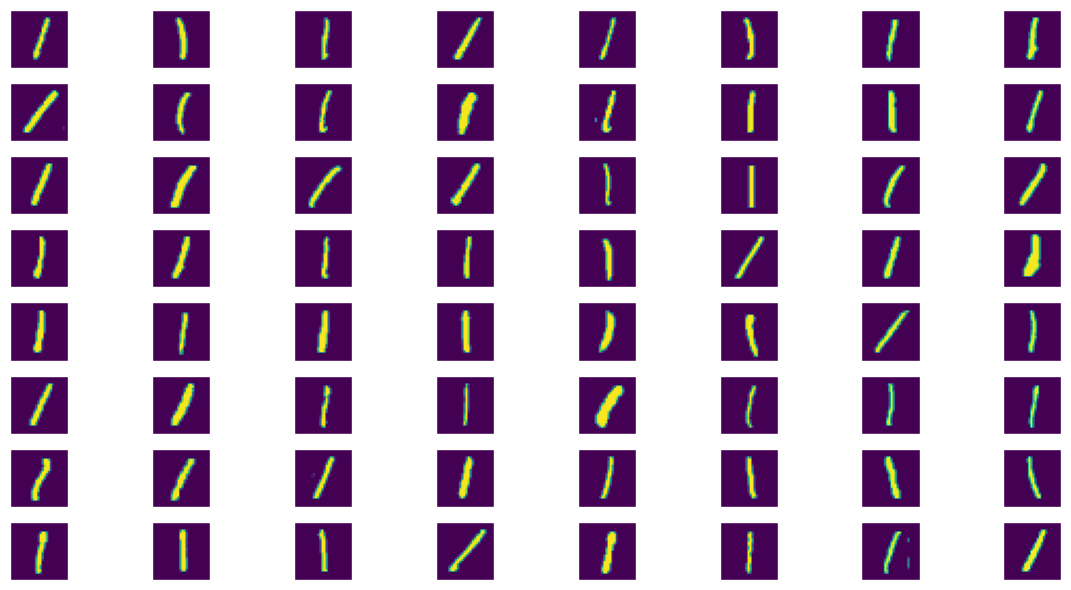

In [69]:
display_images(images=image_batch[0], n_cols=8)

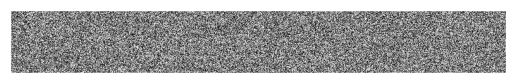

In [70]:
#Sample generation of latent vector
z_size = 784
z = np.random.uniform(-1, 1, size=(100, z_size))
plt.imshow(z, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [71]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.883594 	epoch_g_loss: 1.504393
Epoch [2/400]:
epoch_d_loss: 0.674259 	epoch_g_loss: 2.064678
Epoch [3/400]:
epoch_d_loss: 0.662037 	epoch_g_loss: 3.462359
Epoch [4/400]:
epoch_d_loss: 0.812056 	epoch_g_loss: 5.231957
Epoch [5/400]:
epoch_d_loss: 0.726820 	epoch_g_loss: 4.179422
Epoch [6/400]:
epoch_d_loss: 0.724738 	epoch_g_loss: 3.852358
Epoch [7/400]:
epoch_d_loss: 0.837487 	epoch_g_loss: 3.159995
Epoch [8/400]:
epoch_d_loss: 0.841853 	epoch_g_loss: 2.479016
Epoch [9/400]:
epoch_d_loss: 0.733395 	epoch_g_loss: 2.724808
Epoch [10/400]:
epoch_d_loss: 0.453237 	epoch_g_loss: 3.688833
Epoch [11/400]:
epoch_d_loss: 0.419829 	epoch_g_loss: 3.398702
Epoch [12/400]:
epoch_d_loss: 0.347138 	epoch_g_loss: 2.857199
Epoch [13/400]:
epoch_d_loss: 0.412926 	epoch_g_loss: 3.040009
Epoch [14/400]:
epoch_d_loss: 0.640285 	epoch_g_loss: 1.976487
Epoch [15/400]:
epoch_d_loss: 0.934061 	epoch_g_loss: 1.406497
Epoch [16/400]:
epoch_d_loss: 1.123458 	epoch_g_loss: 1.069948
Epoch [17/400]:


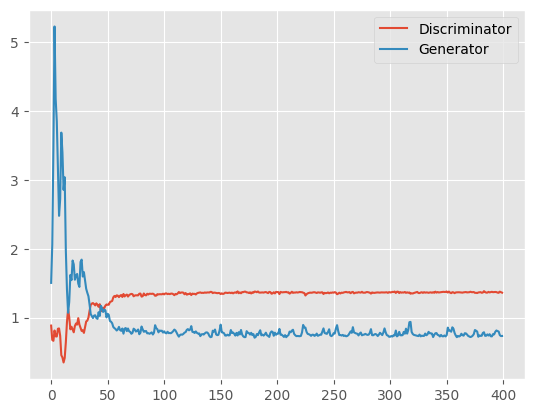

In [72]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

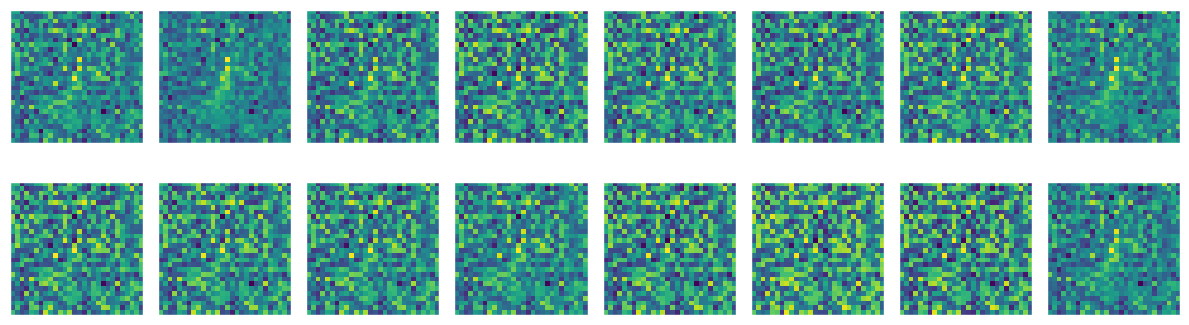

In [73]:
show_generated_images(epoch=1, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

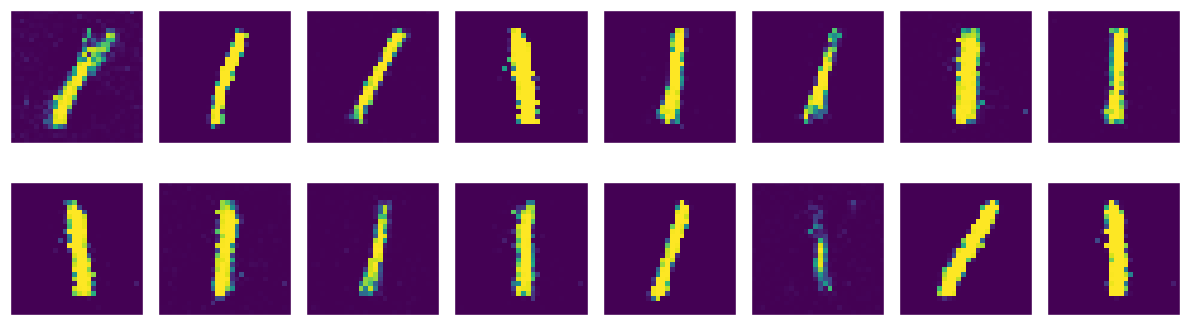

In [74]:
show_generated_images(epoch=100, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

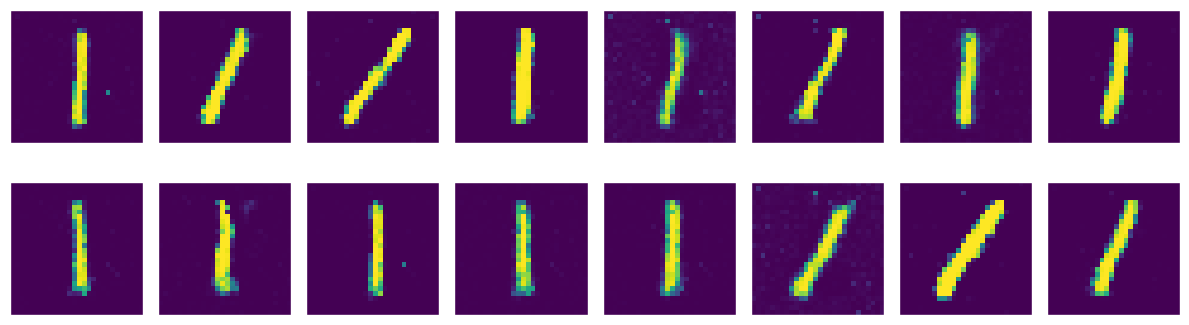

In [75]:
show_generated_images(epoch=200, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

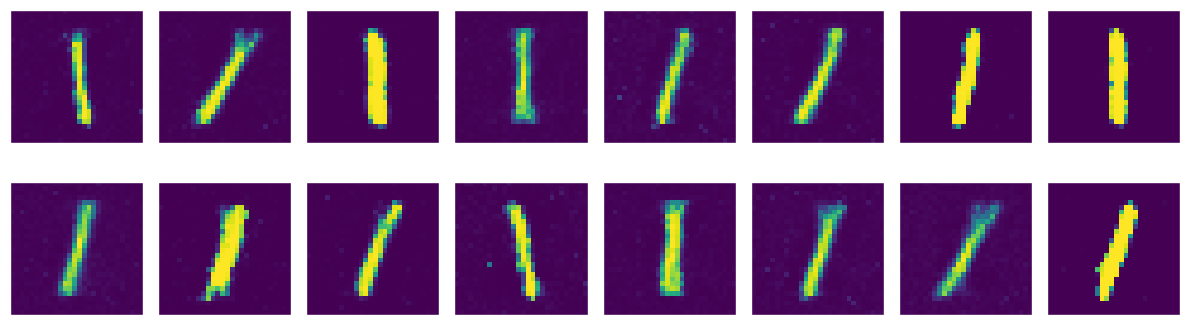

In [76]:
show_generated_images(epoch=400, n_cols=8)

### Test the network

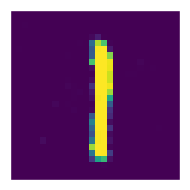

The discriminator s opinion is :  -0.05576029419898987


In [77]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [78]:
torch.save(g.state_dict(), f'./mnist_models/gan-generator-mnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./mnist_models/gan-discriminator-mnist-cl-{cl}.pth')

## Class 2

2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


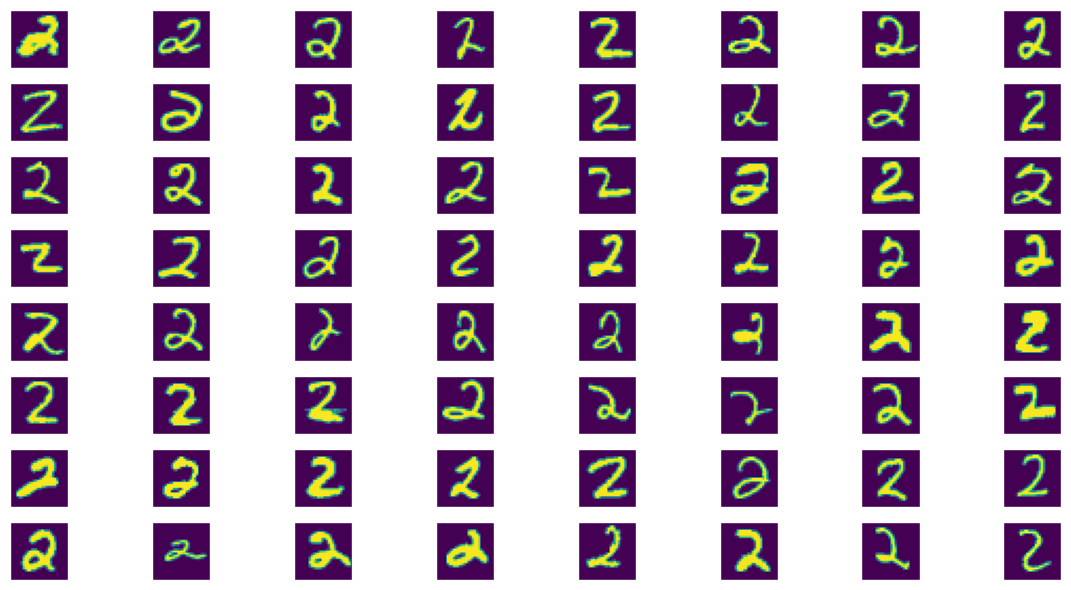

In [79]:
# Datasets
cl = 2
train_data = MNIST_class(cl, True)
test_data = MNIST_class(cl, False)
# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)
# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [80]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.795546 	epoch_g_loss: 2.027986
Epoch [2/400]:
epoch_d_loss: 0.527875 	epoch_g_loss: 3.128922
Epoch [3/400]:
epoch_d_loss: 0.580628 	epoch_g_loss: 4.863599
Epoch [4/400]:
epoch_d_loss: 0.716388 	epoch_g_loss: 4.463335
Epoch [5/400]:
epoch_d_loss: 0.558432 	epoch_g_loss: 5.883143
Epoch [6/400]:
epoch_d_loss: 0.790290 	epoch_g_loss: 4.951258
Epoch [7/400]:
epoch_d_loss: 1.049946 	epoch_g_loss: 1.757743
Epoch [8/400]:
epoch_d_loss: 1.083215 	epoch_g_loss: 1.646310
Epoch [9/400]:
epoch_d_loss: 1.089227 	epoch_g_loss: 1.860078
Epoch [10/400]:
epoch_d_loss: 1.012162 	epoch_g_loss: 2.106567
Epoch [11/400]:
epoch_d_loss: 1.084545 	epoch_g_loss: 1.479308
Epoch [12/400]:
epoch_d_loss: 1.206083 	epoch_g_loss: 1.406998
Epoch [13/400]:
epoch_d_loss: 1.224088 	epoch_g_loss: 1.332583
Epoch [14/400]:
epoch_d_loss: 1.145485 	epoch_g_loss: 1.082916
Epoch [15/400]:
epoch_d_loss: 0.916078 	epoch_g_loss: 1.785708
Epoch [16/400]:
epoch_d_loss: 0.727806 	epoch_g_loss: 3.167772
Epoch [17/400]:


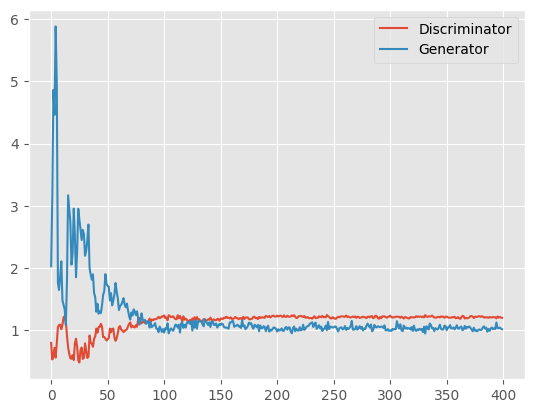

In [81]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

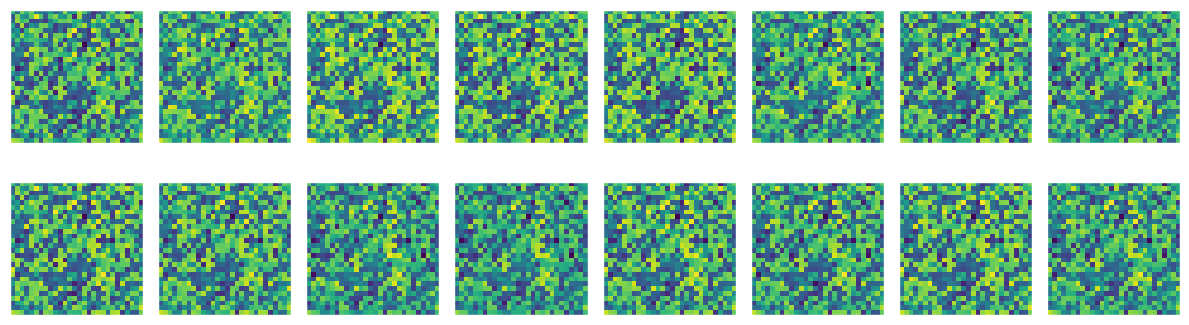

In [82]:
show_generated_images(epoch=1, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

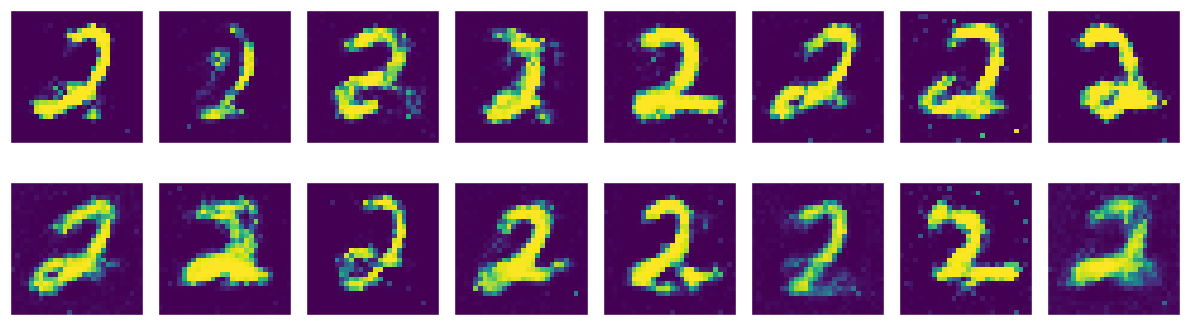

In [83]:
show_generated_images(epoch=200, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

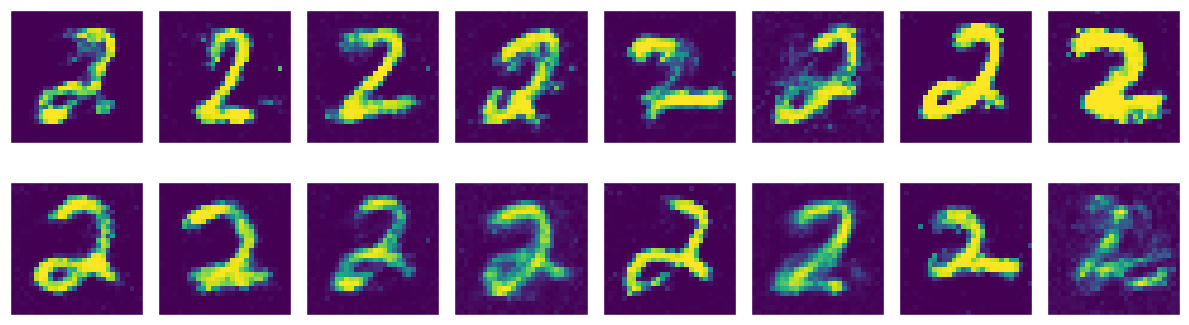

In [84]:
show_generated_images(epoch=400, n_cols=8)

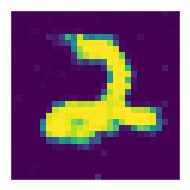

The discriminator s opinion is :  -0.6390914916992188


In [85]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [86]:
torch.save(g.state_dict(), f'./mnist_models/gan-generator-mnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./mnist_models/gan-discriminator-mnist-cl-{cl}.pth')

In [87]:
z = np.random.uniform(-1, 1, size=(3, 784))
z = torch.from_numpy(z).float()
imgs = g(z)
imgs.shape

torch.Size([3, 784])

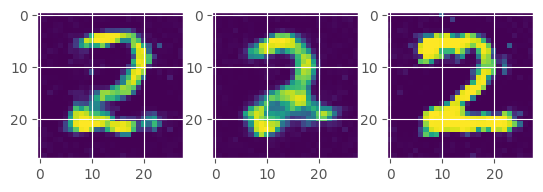

In [88]:
fig, ax = plt.subplots(1, 3)
for i, img in enumerate(imgs):
    im = img.cpu().detach().numpy()
    ax[i].imshow(im.reshape(28, 28))

## Class 3

2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


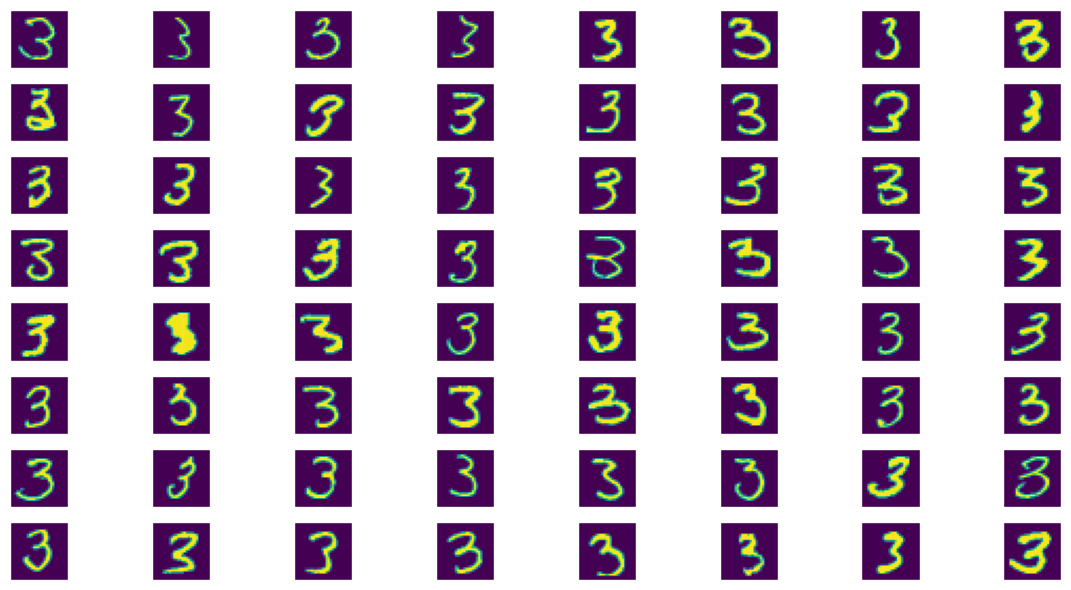

In [89]:
# Datasets
cl = 3
train_data = MNIST_class(cl, True)
test_data = MNIST_class(cl, False)
# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)
# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [90]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.721024 	epoch_g_loss: 2.415114
Epoch [2/400]:
epoch_d_loss: 0.622270 	epoch_g_loss: 2.350259
Epoch [3/400]:
epoch_d_loss: 0.556744 	epoch_g_loss: 4.028350
Epoch [4/400]:
epoch_d_loss: 0.864374 	epoch_g_loss: 3.352807
Epoch [5/400]:
epoch_d_loss: 0.836407 	epoch_g_loss: 3.685750
Epoch [6/400]:
epoch_d_loss: 0.817469 	epoch_g_loss: 4.607522
Epoch [7/400]:
epoch_d_loss: 0.886896 	epoch_g_loss: 3.029219
Epoch [8/400]:
epoch_d_loss: 1.148564 	epoch_g_loss: 1.913661
Epoch [9/400]:
epoch_d_loss: 0.988928 	epoch_g_loss: 2.158441
Epoch [10/400]:
epoch_d_loss: 1.170396 	epoch_g_loss: 1.239890
Epoch [11/400]:
epoch_d_loss: 1.152408 	epoch_g_loss: 1.362610
Epoch [12/400]:
epoch_d_loss: 1.117960 	epoch_g_loss: 1.184403
Epoch [13/400]:
epoch_d_loss: 0.989775 	epoch_g_loss: 1.374277
Epoch [14/400]:
epoch_d_loss: 0.849998 	epoch_g_loss: 1.596504
Epoch [15/400]:
epoch_d_loss: 0.860762 	epoch_g_loss: 1.534882
Epoch [16/400]:
epoch_d_loss: 0.669955 	epoch_g_loss: 1.524582
Epoch [17/400]:


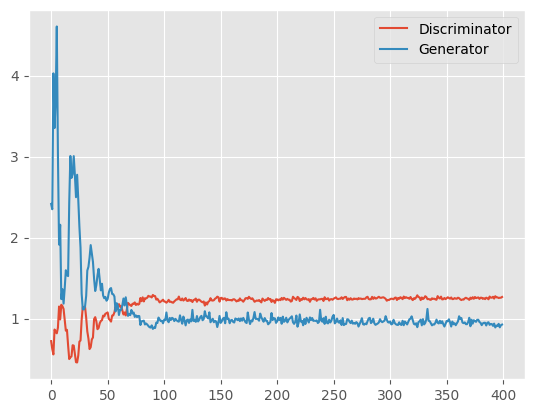

In [91]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

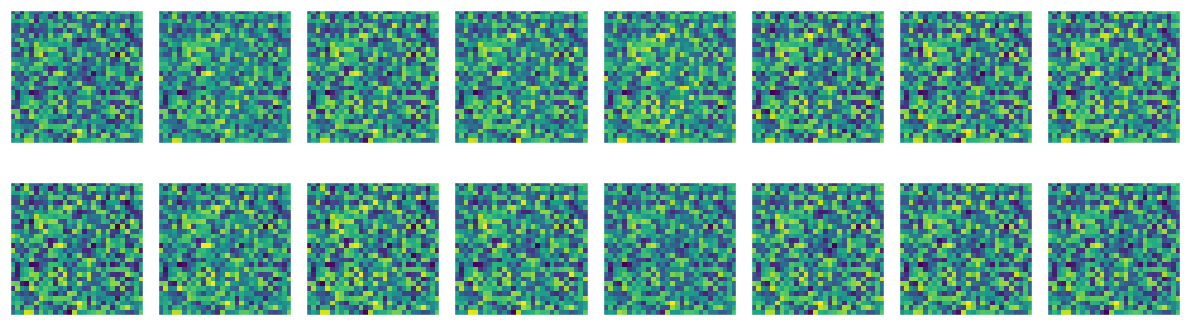

In [92]:
show_generated_images(epoch=1, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

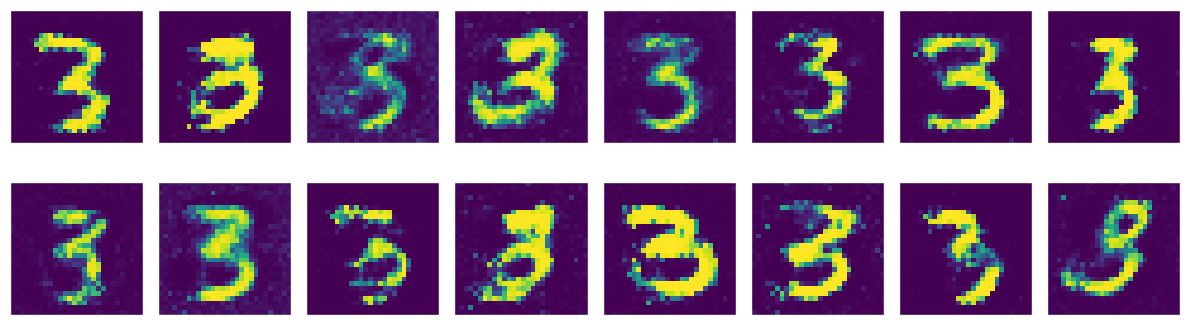

In [93]:
show_generated_images(epoch=200, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

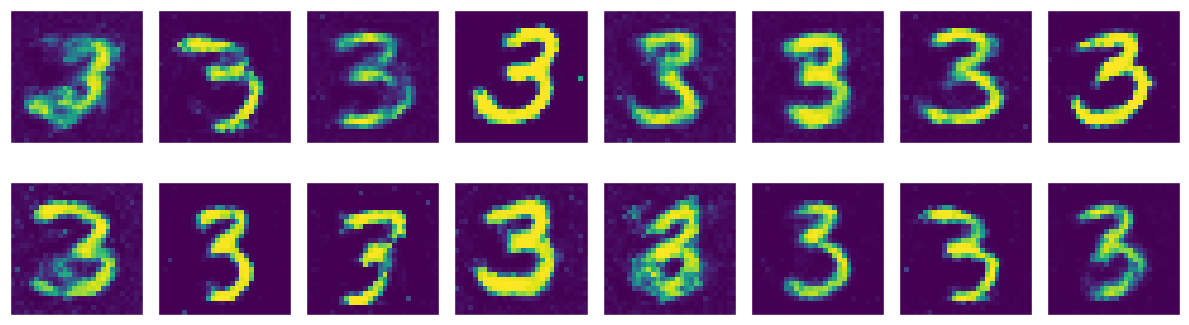

In [94]:
show_generated_images(epoch=400, n_cols=8)

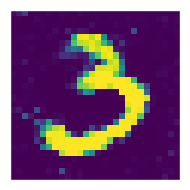

The discriminator s opinion is :  0.4889914095401764


In [95]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [96]:
torch.save(g.state_dict(), f'./mnist_models/gan-generator-mnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./mnist_models/gan-discriminator-mnist-cl-{cl}.pth')

## Class 4

2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


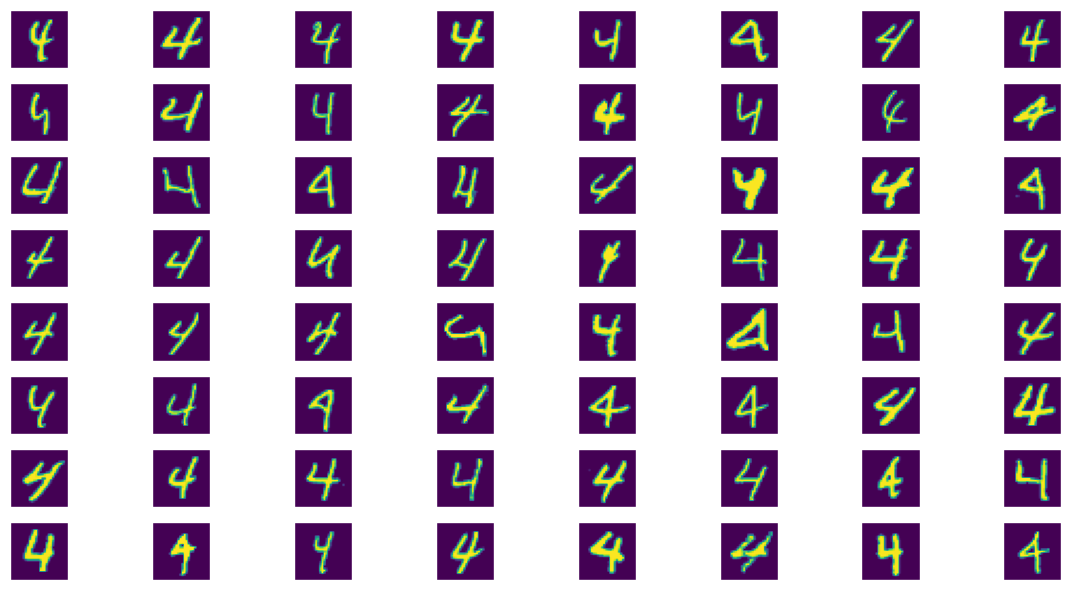

In [97]:
# Datasets
cl = 4
train_data = MNIST_class(cl, True)
test_data = MNIST_class(cl, False)
# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)
# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [98]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.733804 	epoch_g_loss: 2.058971
Epoch [2/400]:
epoch_d_loss: 0.539191 	epoch_g_loss: 2.931025
Epoch [3/400]:
epoch_d_loss: 0.386619 	epoch_g_loss: 5.294587
Epoch [4/400]:
epoch_d_loss: 0.735411 	epoch_g_loss: 3.612292
Epoch [5/400]:
epoch_d_loss: 0.527262 	epoch_g_loss: 5.483344
Epoch [6/400]:
epoch_d_loss: 0.866358 	epoch_g_loss: 3.351408
Epoch [7/400]:
epoch_d_loss: 1.005114 	epoch_g_loss: 2.231505
Epoch [8/400]:
epoch_d_loss: 1.064249 	epoch_g_loss: 1.966004
Epoch [9/400]:
epoch_d_loss: 1.004349 	epoch_g_loss: 2.333526
Epoch [10/400]:
epoch_d_loss: 0.731497 	epoch_g_loss: 3.101290
Epoch [11/400]:
epoch_d_loss: 0.938849 	epoch_g_loss: 2.835221
Epoch [12/400]:
epoch_d_loss: 0.859060 	epoch_g_loss: 2.729639
Epoch [13/400]:
epoch_d_loss: 0.822126 	epoch_g_loss: 2.261977
Epoch [14/400]:
epoch_d_loss: 0.919498 	epoch_g_loss: 1.572601
Epoch [15/400]:
epoch_d_loss: 0.859286 	epoch_g_loss: 1.881824
Epoch [16/400]:
epoch_d_loss: 0.749524 	epoch_g_loss: 1.921298
Epoch [17/400]:


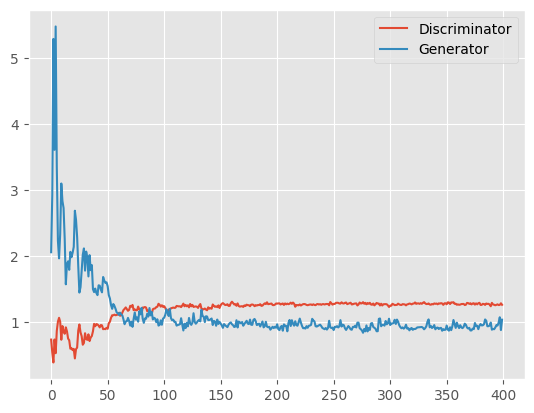

In [99]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

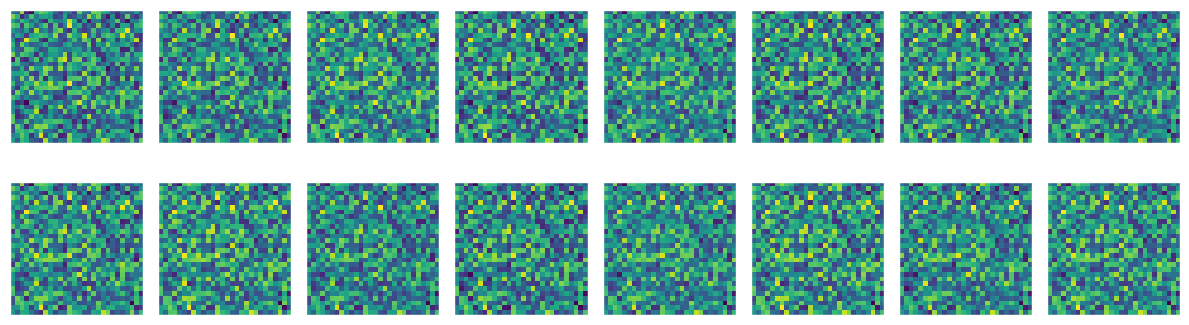

In [100]:
show_generated_images(epoch=1, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

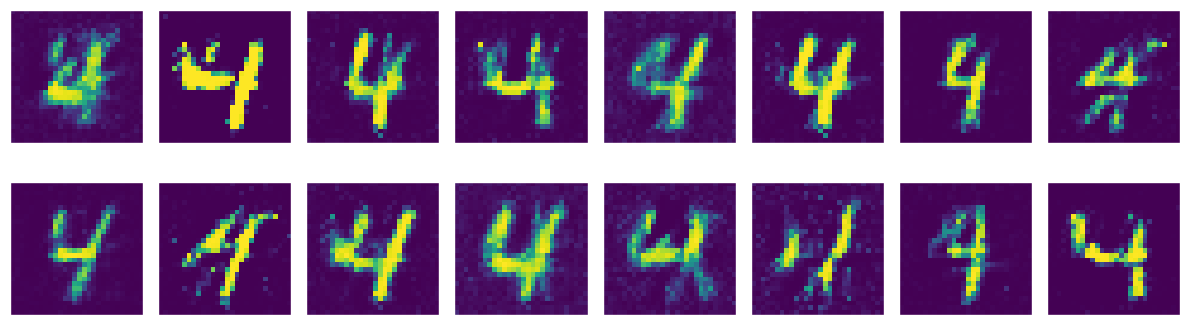

In [101]:
show_generated_images(epoch=200, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

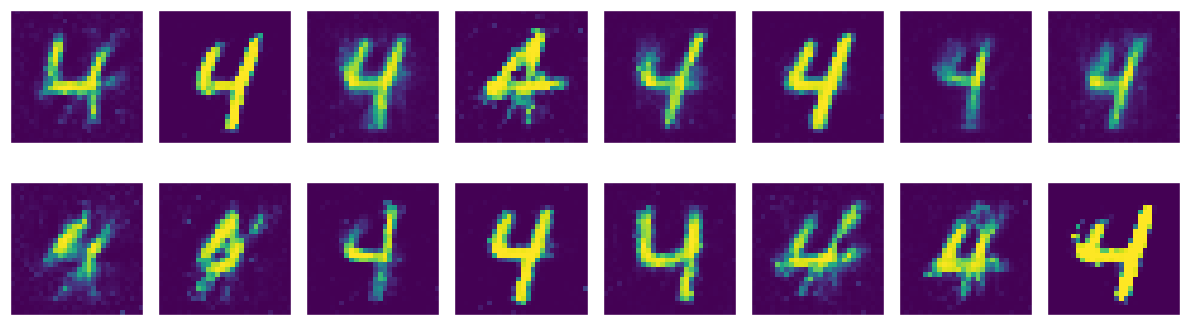

In [102]:
show_generated_images(epoch=400, n_cols=8)

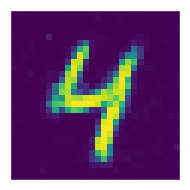

The discriminator s opinion is :  -0.5107417106628418


In [103]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [104]:
torch.save(g.state_dict(), f'./mnist_models/gan-generator-mnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./mnist_models/gan-discriminator-mnist-cl-{cl}.pth')

## Class 5

2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


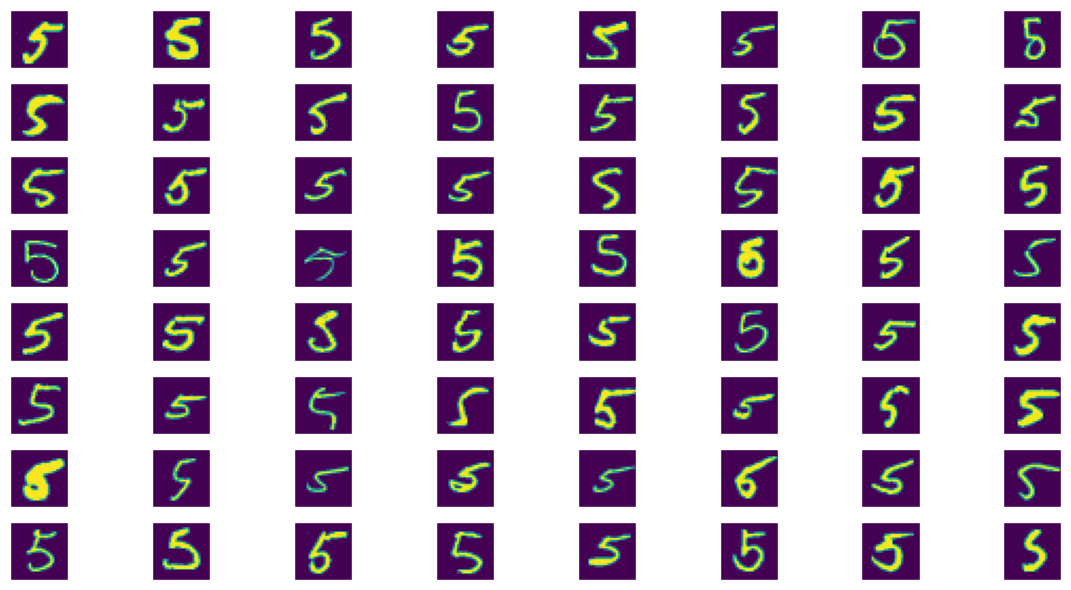

In [105]:
# Datasets
cl = 5
train_data = MNIST_class(cl, True)
test_data = MNIST_class(cl, False)
# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)
# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [106]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.746887 	epoch_g_loss: 1.915834
Epoch [2/400]:
epoch_d_loss: 0.420409 	epoch_g_loss: 3.868546
Epoch [3/400]:
epoch_d_loss: 0.589551 	epoch_g_loss: 2.913229
Epoch [4/400]:
epoch_d_loss: 0.814766 	epoch_g_loss: 3.238146
Epoch [5/400]:
epoch_d_loss: 0.755946 	epoch_g_loss: 4.580440
Epoch [6/400]:
epoch_d_loss: 0.935091 	epoch_g_loss: 2.980615
Epoch [7/400]:
epoch_d_loss: 1.082509 	epoch_g_loss: 1.814418
Epoch [8/400]:
epoch_d_loss: 0.973074 	epoch_g_loss: 2.029204
Epoch [9/400]:
epoch_d_loss: 1.002987 	epoch_g_loss: 2.126270
Epoch [10/400]:
epoch_d_loss: 1.126420 	epoch_g_loss: 1.710299
Epoch [11/400]:
epoch_d_loss: 0.908536 	epoch_g_loss: 1.872675
Epoch [12/400]:
epoch_d_loss: 0.788061 	epoch_g_loss: 2.476445
Epoch [13/400]:
epoch_d_loss: 0.785867 	epoch_g_loss: 1.777407
Epoch [14/400]:
epoch_d_loss: 0.629704 	epoch_g_loss: 2.089105
Epoch [15/400]:
epoch_d_loss: 0.493067 	epoch_g_loss: 2.679487
Epoch [16/400]:
epoch_d_loss: 0.495034 	epoch_g_loss: 2.729256
Epoch [17/400]:


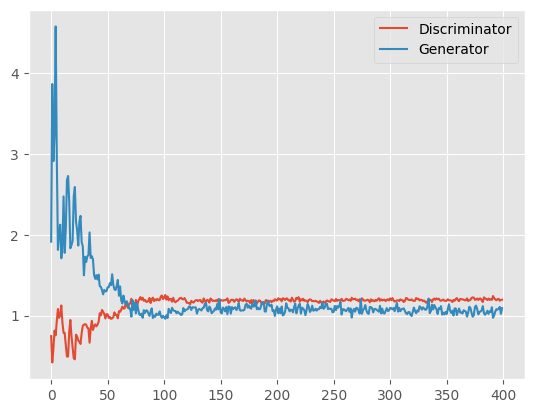

In [107]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

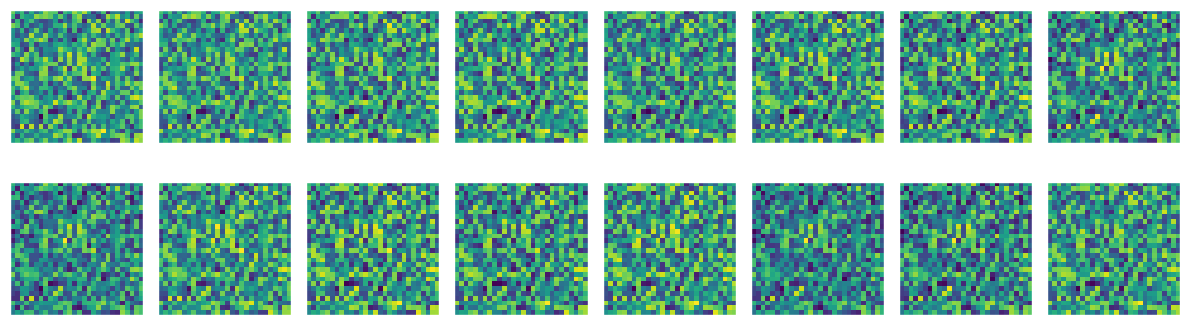

In [108]:
show_generated_images(epoch=1, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

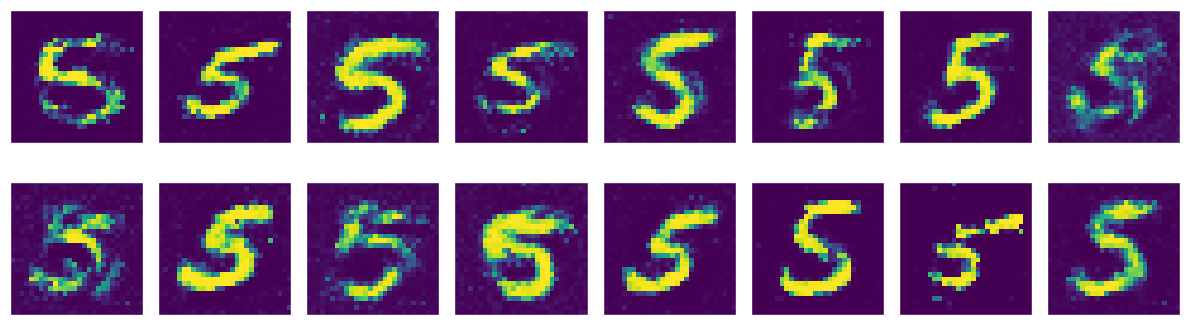

In [109]:
show_generated_images(epoch=200, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

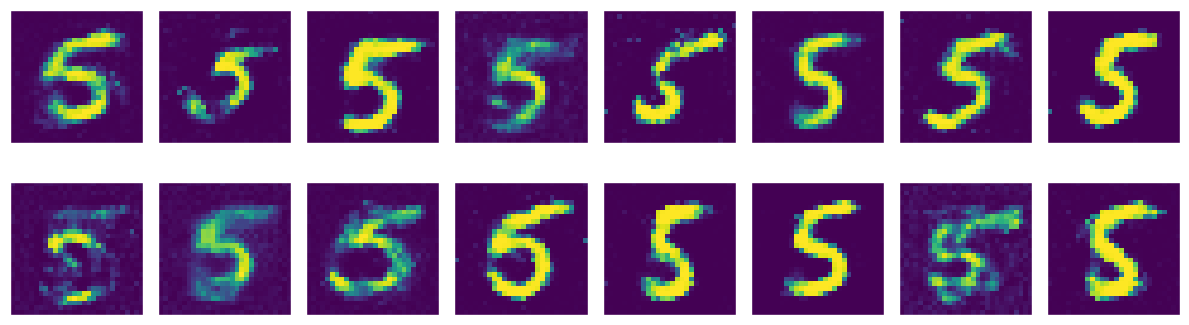

In [110]:
show_generated_images(epoch=400, n_cols=8)

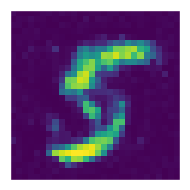

The discriminator s opinion is :  -0.30634644627571106


In [111]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [112]:
torch.save(g.state_dict(), f'./mnist_models/gan-generator-mnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./mnist_models/gan-discriminator-mnist-cl-{cl}.pth')

## Class 6

2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


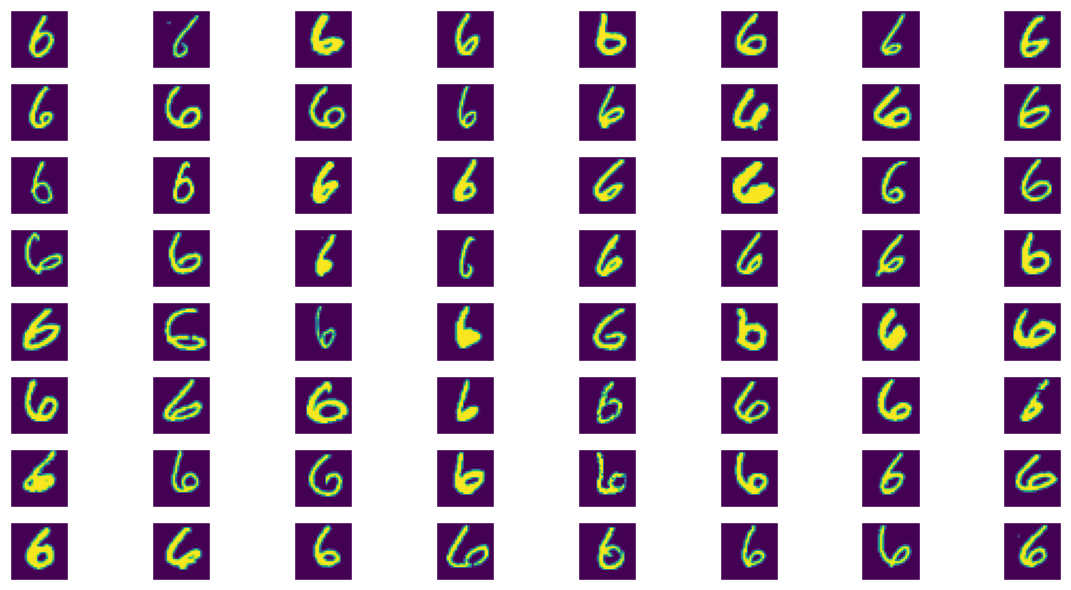

In [113]:
# Datasets
cl = 6
train_data = MNIST_class(cl, True)
test_data = MNIST_class(cl, False)
# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)
# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [114]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.809210 	epoch_g_loss: 1.904619
Epoch [2/400]:
epoch_d_loss: 0.475236 	epoch_g_loss: 3.110638
Epoch [3/400]:
epoch_d_loss: 0.644313 	epoch_g_loss: 3.313966
Epoch [4/400]:
epoch_d_loss: 0.694694 	epoch_g_loss: 3.371968
Epoch [5/400]:
epoch_d_loss: 0.907089 	epoch_g_loss: 3.707014
Epoch [6/400]:
epoch_d_loss: 0.982329 	epoch_g_loss: 3.111615
Epoch [7/400]:
epoch_d_loss: 0.990791 	epoch_g_loss: 2.475208
Epoch [8/400]:
epoch_d_loss: 0.866838 	epoch_g_loss: 2.518193
Epoch [9/400]:
epoch_d_loss: 0.929752 	epoch_g_loss: 2.019958
Epoch [10/400]:
epoch_d_loss: 0.772895 	epoch_g_loss: 2.999420
Epoch [11/400]:
epoch_d_loss: 0.868815 	epoch_g_loss: 1.871579
Epoch [12/400]:
epoch_d_loss: 0.657617 	epoch_g_loss: 2.514177
Epoch [13/400]:
epoch_d_loss: 0.686023 	epoch_g_loss: 2.567421
Epoch [14/400]:
epoch_d_loss: 0.634251 	epoch_g_loss: 2.175977
Epoch [15/400]:
epoch_d_loss: 0.515805 	epoch_g_loss: 3.209302
Epoch [16/400]:
epoch_d_loss: 0.419559 	epoch_g_loss: 2.860743
Epoch [17/400]:


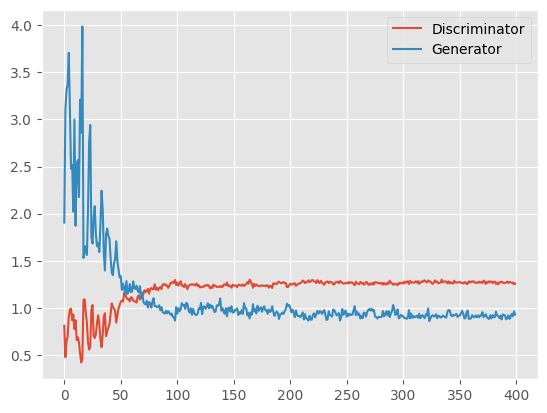

In [115]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

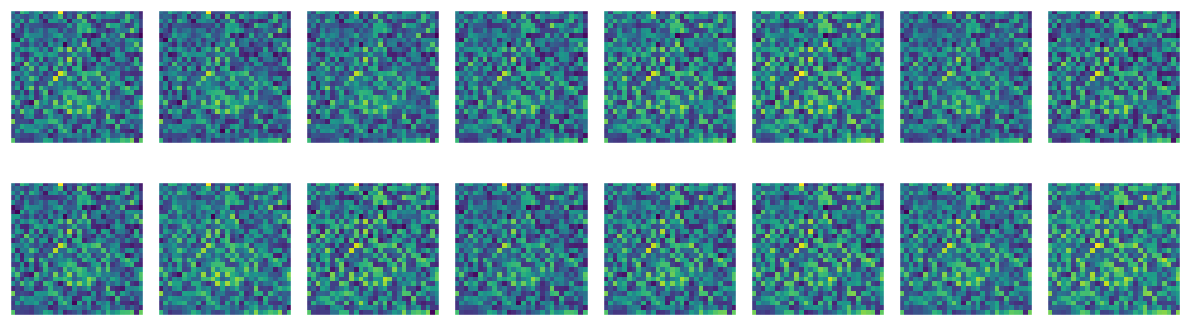

In [116]:
show_generated_images(epoch=1, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

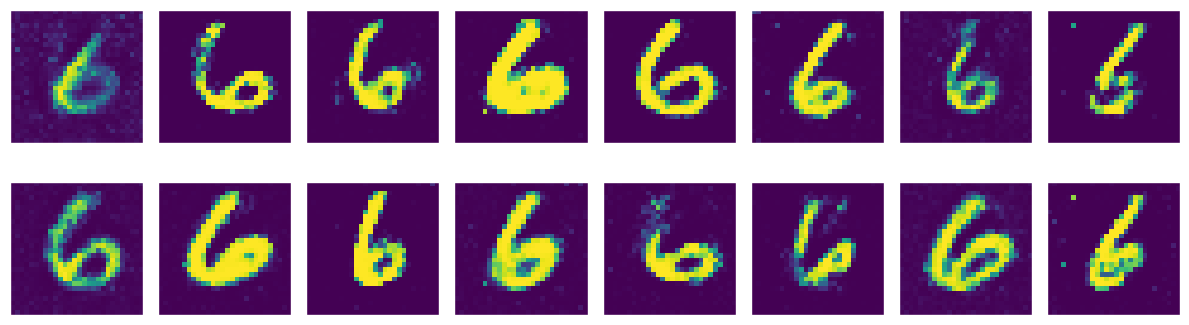

In [117]:
show_generated_images(epoch=200, n_cols=8)

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

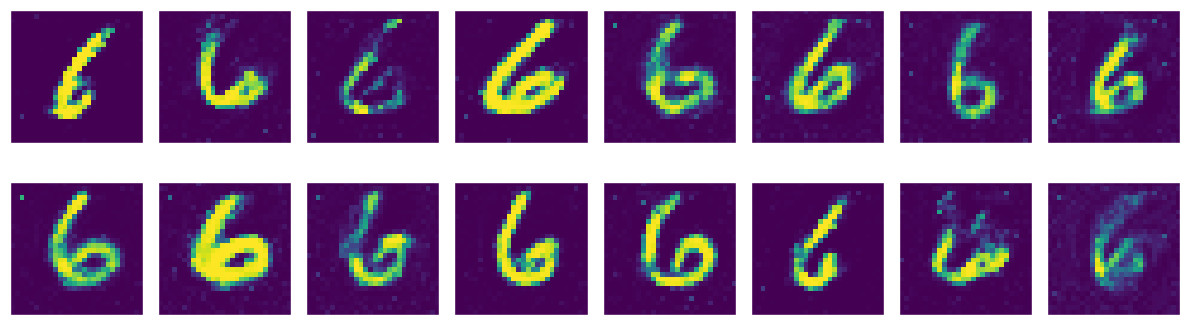

In [118]:
show_generated_images(epoch=400, n_cols=8)

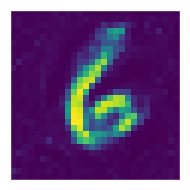

The discriminator s opinion is :  -0.36054134368896484


In [119]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [120]:
torch.save(g.state_dict(), f'./mnist_models/gan-generator-mnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./mnist_models/gan-discriminator-mnist-cl-{cl}.pth')

## Class 7

2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


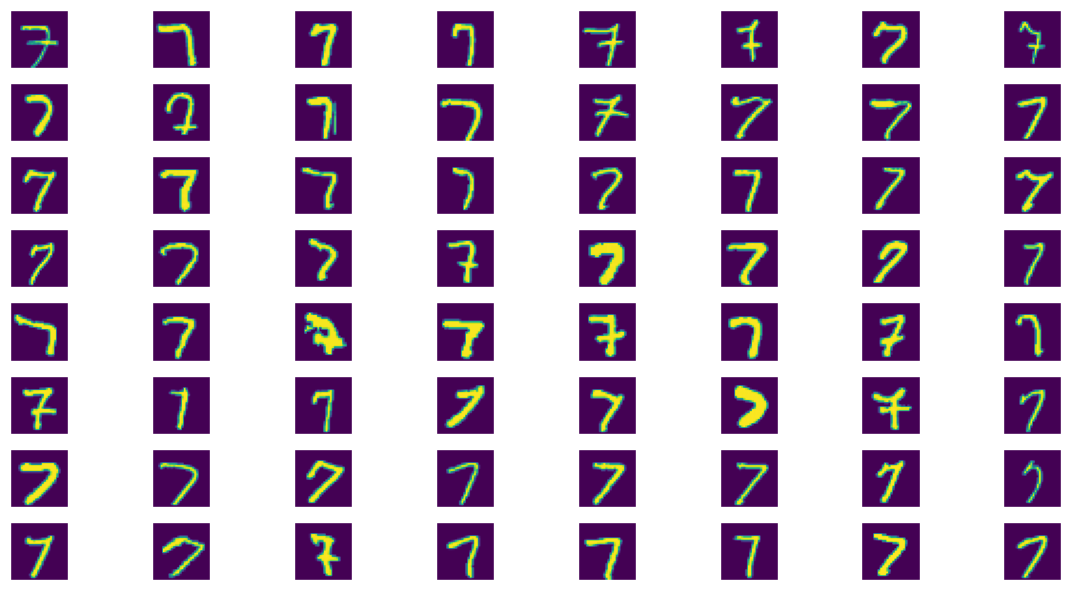

In [121]:
# Datasets
cl = 7
train_data = MNIST_class(cl, True)
test_data = MNIST_class(cl, False)
# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)
# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [122]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.765730 	epoch_g_loss: 1.635692
Epoch [2/400]:
epoch_d_loss: 0.734638 	epoch_g_loss: 2.377910
Epoch [3/400]:
epoch_d_loss: 0.824902 	epoch_g_loss: 2.777564
Epoch [4/400]:
epoch_d_loss: 0.870494 	epoch_g_loss: 3.634451
Epoch [5/400]:
epoch_d_loss: 0.826520 	epoch_g_loss: 2.819678
Epoch [6/400]:
epoch_d_loss: 1.123374 	epoch_g_loss: 2.050660
Epoch [7/400]:
epoch_d_loss: 0.936067 	epoch_g_loss: 2.573074
Epoch [8/400]:
epoch_d_loss: 0.888232 	epoch_g_loss: 2.967298
Epoch [9/400]:
epoch_d_loss: 0.829078 	epoch_g_loss: 2.681911
Epoch [10/400]:
epoch_d_loss: 0.811566 	epoch_g_loss: 1.806286
Epoch [11/400]:
epoch_d_loss: 0.540460 	epoch_g_loss: 2.285548
Epoch [12/400]:
epoch_d_loss: 0.254193 	epoch_g_loss: 3.796077
Epoch [13/400]:
epoch_d_loss: 0.583597 	epoch_g_loss: 3.952541
Epoch [14/400]:
epoch_d_loss: 0.969395 	epoch_g_loss: 1.878022
Epoch [15/400]:
epoch_d_loss: 0.734671 	epoch_g_loss: 2.007514
Epoch [16/400]:
epoch_d_loss: 0.457782 	epoch_g_loss: 2.820311
Epoch [17/400]:


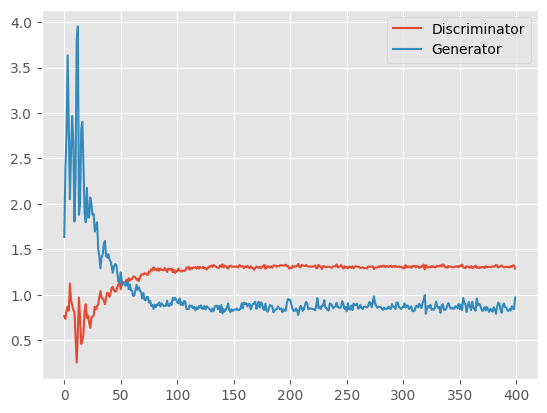

In [123]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

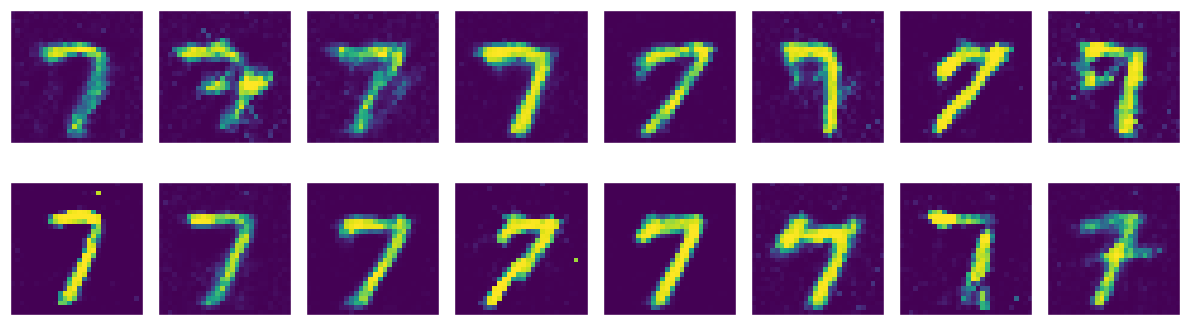

In [124]:
show_generated_images(epoch=400, n_cols=8)

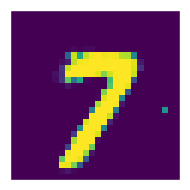

The discriminator s opinion is :  -0.3280859589576721


In [125]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [126]:
torch.save(g.state_dict(), f'./mnist_models/gan-generator-mnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./mnist_models/gan-discriminator-mnist-cl-{cl}.pth')

## Class 8

2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


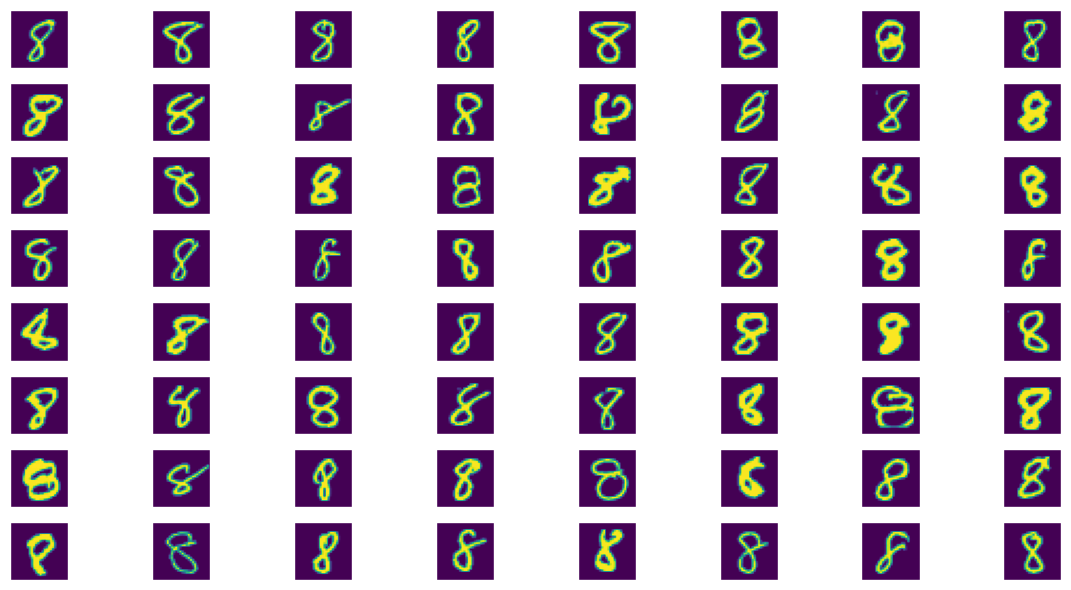

In [127]:
# Datasets
cl = 8
train_data = MNIST_class(cl, True)
test_data = MNIST_class(cl, False)
# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)
# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [128]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.882436 	epoch_g_loss: 1.479890
Epoch [2/400]:
epoch_d_loss: 0.581487 	epoch_g_loss: 2.985045
Epoch [3/400]:
epoch_d_loss: 0.796078 	epoch_g_loss: 2.083641
Epoch [4/400]:
epoch_d_loss: 0.855204 	epoch_g_loss: 2.528887
Epoch [5/400]:
epoch_d_loss: 0.850807 	epoch_g_loss: 3.164784
Epoch [6/400]:
epoch_d_loss: 0.974260 	epoch_g_loss: 2.551116
Epoch [7/400]:
epoch_d_loss: 0.878139 	epoch_g_loss: 2.809005
Epoch [8/400]:
epoch_d_loss: 1.049196 	epoch_g_loss: 1.909330
Epoch [9/400]:
epoch_d_loss: 1.017793 	epoch_g_loss: 2.030949
Epoch [10/400]:
epoch_d_loss: 1.010058 	epoch_g_loss: 2.650541
Epoch [11/400]:
epoch_d_loss: 1.024568 	epoch_g_loss: 1.590013
Epoch [12/400]:
epoch_d_loss: 1.306448 	epoch_g_loss: 1.441629
Epoch [13/400]:
epoch_d_loss: 1.084762 	epoch_g_loss: 1.297470
Epoch [14/400]:
epoch_d_loss: 1.253779 	epoch_g_loss: 1.439334
Epoch [15/400]:
epoch_d_loss: 1.028322 	epoch_g_loss: 1.106406
Epoch [16/400]:
epoch_d_loss: 0.965537 	epoch_g_loss: 1.414378
Epoch [17/400]:


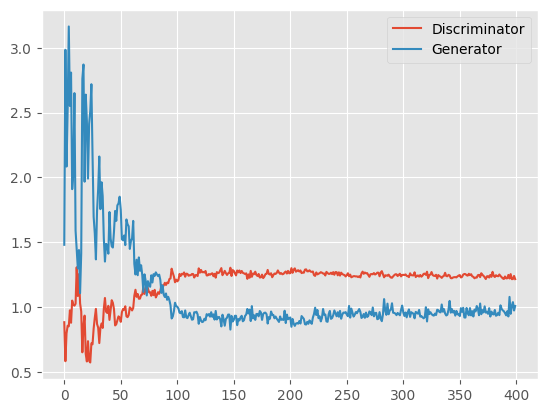

In [129]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

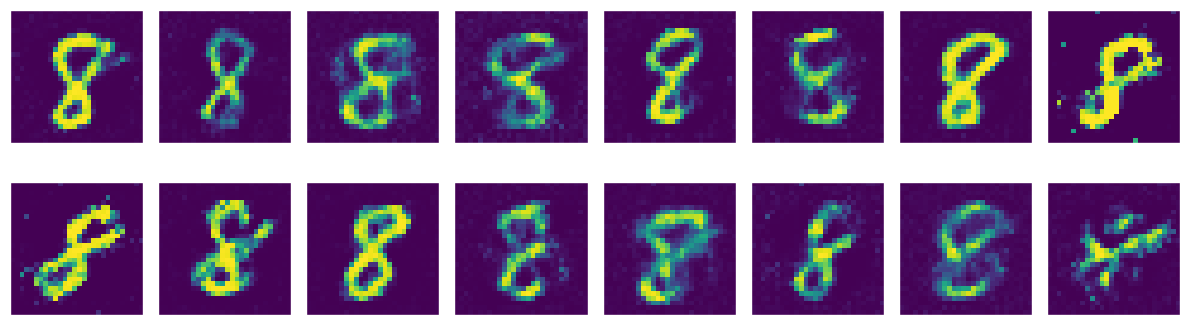

In [130]:
show_generated_images(epoch=400, n_cols=8)

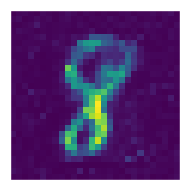

The discriminator s opinion is :  -1.0368833541870117


In [131]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [132]:
torch.save(g.state_dict(), f'./mnist_models/gan-generator-mnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./mnist_models/gan-discriminator-mnist-cl-{cl}.pth')

## Class 9

2 <class 'list'>
torch.Size([64, 28, 28])
torch.Size([64])


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


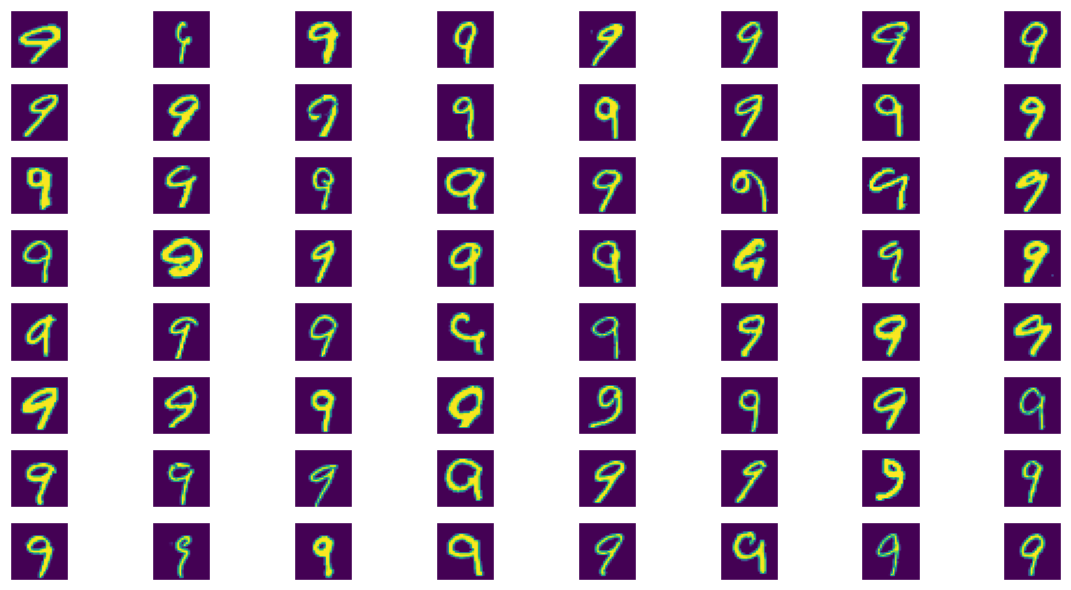

In [133]:
# Datasets
cl = 9
train_data = MNIST_class(cl, True)
test_data = MNIST_class(cl, False)
# Dataloaders
train_loader = DataLoader(dataset= train_data, batch_size = 64, shuffle= True)
test_loader = DataLoader(dataset= test_data, batch_size = 64, shuffle= False)
# Examine a sample batch from the dataloader
image_batch = next(iter(train_loader))
print(len(image_batch), type(image_batch))
print(image_batch[0].shape)
print(image_batch[1].shape)
display_images(images=image_batch[0], n_cols=8)

In [134]:
##
## Prepare and start training
##

# Instantiate Discriminator and Generator
z_size = 784
d = Discriminator(in_features=784, out_features=1)
#g = Generator(in_features=100, out_features=784)
g = Generator(in_features=z_size, out_features=784)
print(d)
print()
print(g)

# Instantiate optimizers
d_optim = optim.Adam(d.parameters(), lr=0.002)
g_optim = optim.Adam(g.parameters(), lr=0.001)

# Instantiate the loss function
loss_fn = nn.BCEWithLogitsLoss()

# Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Train
n_epochs = 400
d_losses, g_losses = train_minst_gan(d, g, z_size, d_optim, g_optim, 
                                     loss_fn, train_loader, n_epochs, device,
                                     verbose=False)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (leaky_relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (leaky_relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (relu2): LeakyReLU(negative_slope=0.2)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (relu3): LeakyReLU(negative_slope=0.2)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (tanh): Tanh()
)
Training on [cpu]...
Epoch [1/400]:


/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(self.X[index], dtype = torch.float)
/var/folders/md/73tlwn611t99m1h0qypsxykc0000gn/T/ipykernel_3226/2521072438.py:15: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  y = torch.tensor(self.y[index], dtype= torch.long)


epoch_d_loss: 0.647108 	epoch_g_loss: 2.072899
Epoch [2/400]:
epoch_d_loss: 0.471873 	epoch_g_loss: 3.870684
Epoch [3/400]:
epoch_d_loss: 0.385721 	epoch_g_loss: 5.146360
Epoch [4/400]:
epoch_d_loss: 0.837083 	epoch_g_loss: 3.991120
Epoch [5/400]:
epoch_d_loss: 0.661889 	epoch_g_loss: 4.777991
Epoch [6/400]:
epoch_d_loss: 0.971612 	epoch_g_loss: 3.295446
Epoch [7/400]:
epoch_d_loss: 0.945322 	epoch_g_loss: 2.367987
Epoch [8/400]:
epoch_d_loss: 0.905941 	epoch_g_loss: 3.397301
Epoch [9/400]:
epoch_d_loss: 0.913095 	epoch_g_loss: 2.710271
Epoch [10/400]:
epoch_d_loss: 0.929518 	epoch_g_loss: 2.212487
Epoch [11/400]:
epoch_d_loss: 1.088034 	epoch_g_loss: 1.876207
Epoch [12/400]:
epoch_d_loss: 1.088726 	epoch_g_loss: 1.254188
Epoch [13/400]:
epoch_d_loss: 0.864397 	epoch_g_loss: 1.616534
Epoch [14/400]:
epoch_d_loss: 0.576196 	epoch_g_loss: 2.562562
Epoch [15/400]:
epoch_d_loss: 0.338491 	epoch_g_loss: 3.395141
Epoch [16/400]:
epoch_d_loss: 0.293045 	epoch_g_loss: 3.845168
Epoch [17/400]:


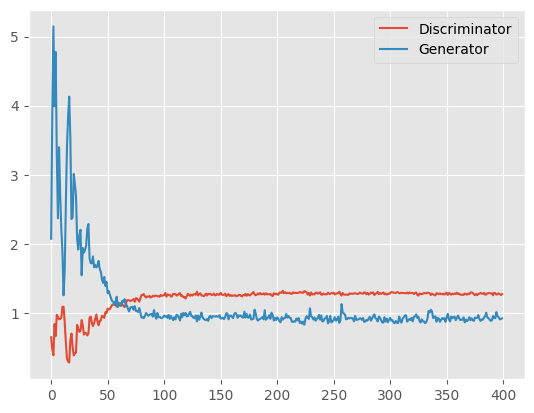

In [135]:
##
## Visualize training losses
##
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()

/Users/aelfirdo/Desktop/Research/TII/Synthetic-data/.venv/lib/python3.9/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(i

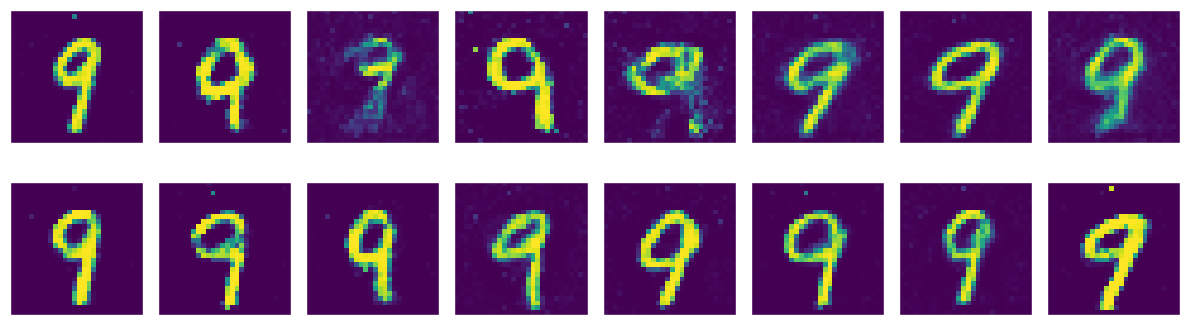

In [136]:
show_generated_images(epoch=400, n_cols=8)

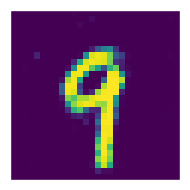

The discriminator s opinion is :  -0.36786380410194397


In [137]:
# Bring generator back to cpu and set eval mode on
g.to('cpu')
g.eval()
# Feed a latent vecor of size 100 to trained generator and get a fake generated image back
z = np.random.uniform(-1, 1, size=(1, 784))
z = torch.from_numpy(z).float()
fake_image = g(z)
# Reshape and display
fake_image = fake_image.view(1, 28, 28).detach()
display_images(fake_image, n_cols=1, figsize=(2, 2))
print("The discriminator s opinion is : ", d(fake_image).view(-1).item())

In [138]:
torch.save(g.state_dict(), f'./mnist_models/gan-generator-mnist-cl-{cl}.pth')
torch.save(d.state_dict(), f'./mnist_models/gan-discriminator-mnist-cl-{cl}.pth')